In [1]:
import os
import sys

# Check if a marker file exists
if not os.path.exists('/content/installed'):
    # Install packages
    !pip install --upgrade --force-reinstall pandas==2.2.2 numpy==1.26.4 tensorflow==2.18.0 numba==0.60.0

    # Create a marker file
    open('/content/installed', 'w').close()

    # Restart runtime
    os.execv(sys.executable, ['python'] + sys.argv)

# Now continue normal code
print("Packages installed and runtime is ready!")

Packages installed and runtime is ready!


In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00


In [3]:
# import libaraies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import warnings
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima


In [4]:
# Suppress all warning messages during execution to keep the output clean
# Useful when using libraries (like statsmodels or sklearn) that raise harmless warnings
warnings.filterwarnings("ignore")

In [5]:
# Import the drive module from Google Colab to facilitate access to Google Drive.
from google.colab import drive

# Mount your Google Drive to the '/content/drive' directory
# This allows you to read from and write to files stored in your Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# import data from My Drive
df_nvidia = pd.read_csv("/content/drive/MyDrive/NVIDIA_STOCK.csv")

In [7]:
# Display the dataframe
df_nvidia.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02,4.929879665374756,4.983749866485596,4.987500190734863,4.862500190734863,4.894499778747559,355616000
3,2018-01-03,5.254334926605225,5.3117499351501465,5.34250020980835,5.09375,5.102499961853027,914704000
4,2018-01-04,5.2820329666137695,5.339749813079834,5.451250076293945,5.317249774932861,5.394000053405762,583268000


In [8]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Price      1699 non-null   object
 1   Adj Close  1698 non-null   object
 2   Close      1698 non-null   object
 3   High       1698 non-null   object
 4   Low        1698 non-null   object
 5   Open       1698 non-null   object
 6   Volume     1698 non-null   object
dtypes: object(7)
memory usage: 93.0+ KB


In [9]:
# Data Cleaning
# Remove unwanted rows
df_nvidia = df_nvidia.iloc[2:]
# Remove rows with missing values
df_nvidia = df_nvidia.dropna()

In [10]:
# Convert object into float
df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] = df_nvidia[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

In [11]:
# Handle missing values
df_nvidia.ffill(inplace=True)

In [12]:
# Convert date column to datetime
df_nvidia.rename(columns={'Price': 'Date'}, inplace=True)
df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'])
df_nvidia = df_nvidia.sort_values(by="Date").reset_index(drop=True)

In [13]:
# Display summary
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2018-01-02,4.929880,4.98375,4.98750,4.86250,4.89450,355616000.0
1,2018-01-03,5.254335,5.31175,5.34250,5.09375,5.10250,914704000.0
2,2018-01-04,5.282033,5.33975,5.45125,5.31725,5.39400,583268000.0
3,2018-01-05,5.326794,5.38500,5.42275,5.27700,5.35475,580124000.0
4,2018-01-08,5.490012,5.55000,5.62500,5.46450,5.51000,881216000.0


In [14]:
# display information
df_nvidia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697 entries, 0 to 1696
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1697 non-null   datetime64[ns]
 1   Adj Close  1697 non-null   float64       
 2   Close      1697 non-null   float64       
 3   High       1697 non-null   float64       
 4   Low        1697 non-null   float64       
 5   Open       1697 non-null   float64       
 6   Volume     1697 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 92.9 KB


In [15]:
# Missing values
df_nvidia.isna().sum()

,0
Date,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [16]:
# Duplicated values
df_nvidia.duplicated().sum()

0

In [17]:
# Summary statistics
df_nvidia.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,1697,1697.000000,1697.000000,1697.000000,1697.000000,1697.000000,1.697000e+03
mean,2021-05-16 04:49:21.461402368,24.797593,24.828411,25.295239,24.315422,24.823341,4.716865e+08
min,2018-01-02 00:00:00,3.151430,3.177000,3.249500,3.111500,3.162250,9.788400e+07
25%,2019-09-10 00:00:00,6.113620,6.161750,6.250000,6.064250,6.166250,3.278440e+08
50%,2021-05-17 00:00:00,13.985092,14.015750,14.243500,13.750000,14.033750,4.349650e+08
75%,2023-01-23 00:00:00,27.088902,27.104000,27.496000,26.613001,27.077999,5.708320e+08
max,2024-09-30 00:00:00,135.559067,135.580002,140.759995,132.419998,139.800003,2.511528e+09
std,NaN,29.221442,29.216014,29.811740,28.570804,29.240504,2.093254e+08


In [18]:
# display correlation
df_nvidia.corr()

,Date,Adj Close,Close,High,Low,Open,Volume
Date,1.000000,0.766104,0.765909,0.765275,0.766219,0.765174,-0.105869
Adj Close,0.766104,1.000000,1.000000,0.999662,0.999763,0.999329,-0.113866
Close,0.765909,1.000000,1.000000,0.999662,0.999763,0.999330,-0.113864
High,0.765275,0.999662,0.999662,1.000000,0.999673,0.999780,-0.109508
Low,0.766219,0.999763,0.999763,0.999673,1.000000,0.999668,-0.117262
Open,0.765174,0.999329,0.999330,0.999780,0.999668,1.000000,-0.112821
Volume,-0.105869,-0.113866,-0.113864,-0.109508,-0.117262,-0.112821,1.000000


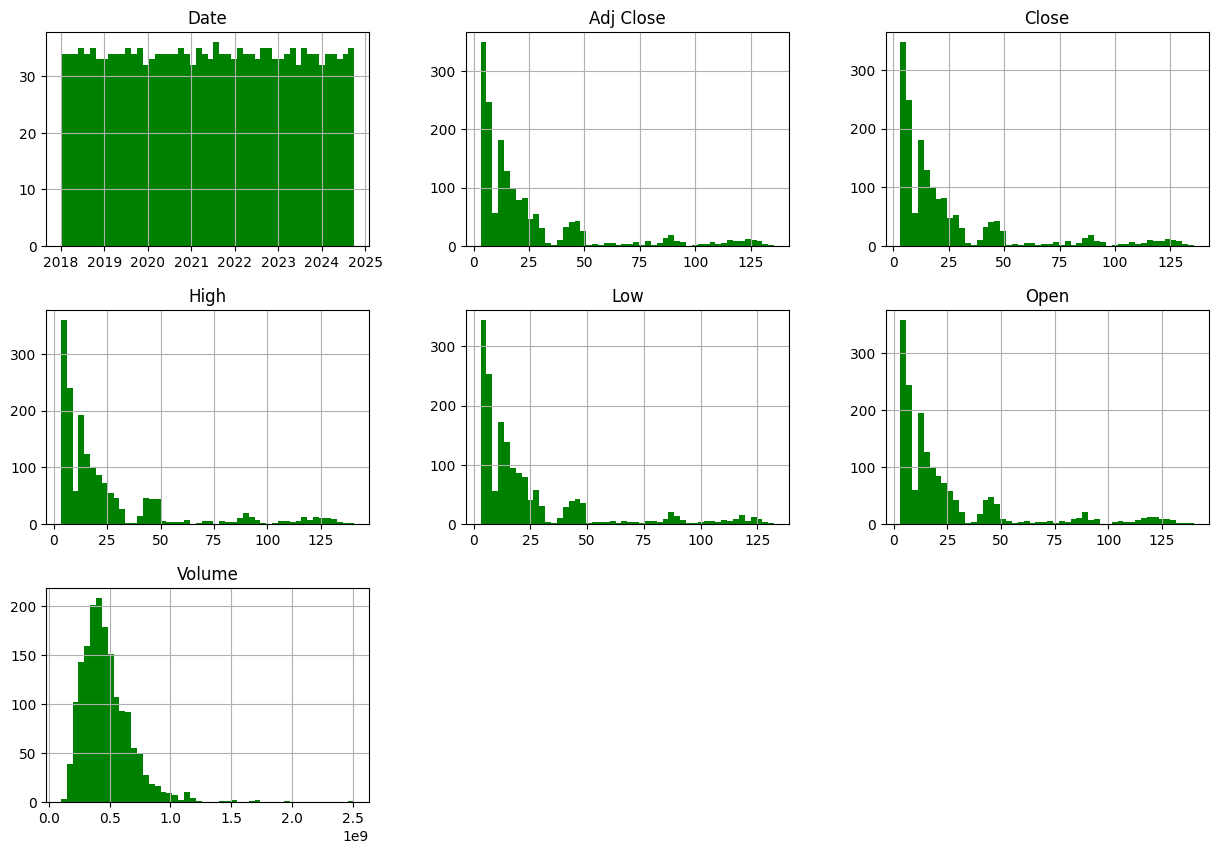

In [19]:
# Create histograms for all numerical columns in the DataFrame
# bins=50 specifies the number of bins (the intervals between bars).
df_nvidia.hist(bins=50, color="green", figsize=(15,10))
plt.savefig('nvidia-histrogram.png')
plt.show()

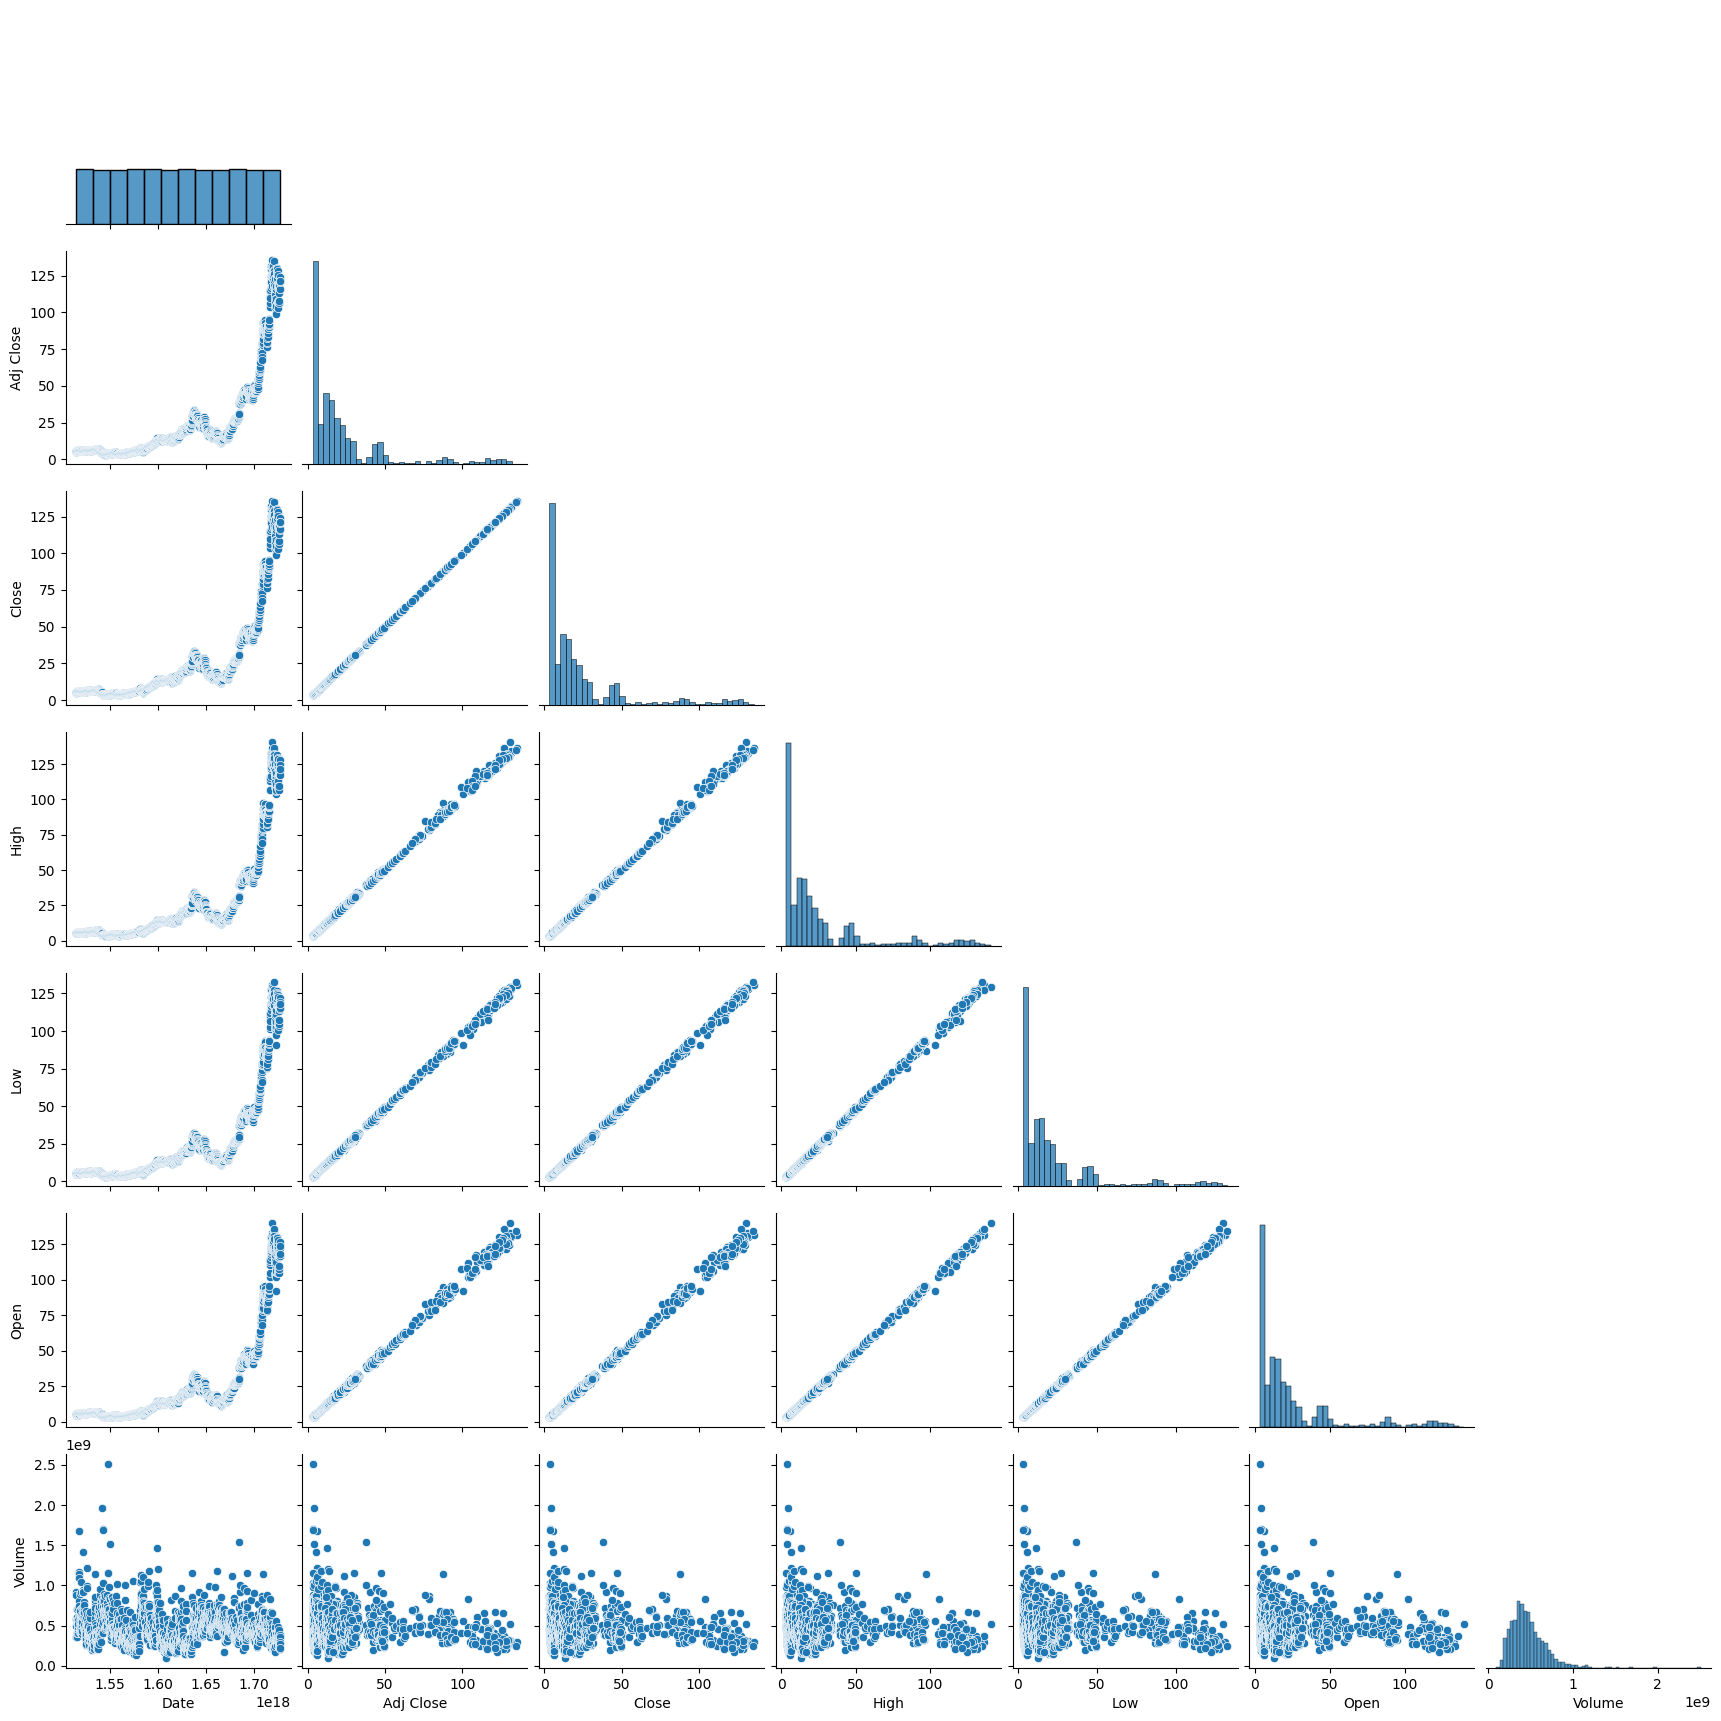

In [20]:
# Looking at some real data, where we don't know the number of clusters already
for col in df_nvidia.columns:
    df_nvidia[col] = pd.to_numeric(df_nvidia[col])

sns.pairplot(df_nvidia, corner=True)
plt.savefig('nvidia-cluster.png')
plt.show()

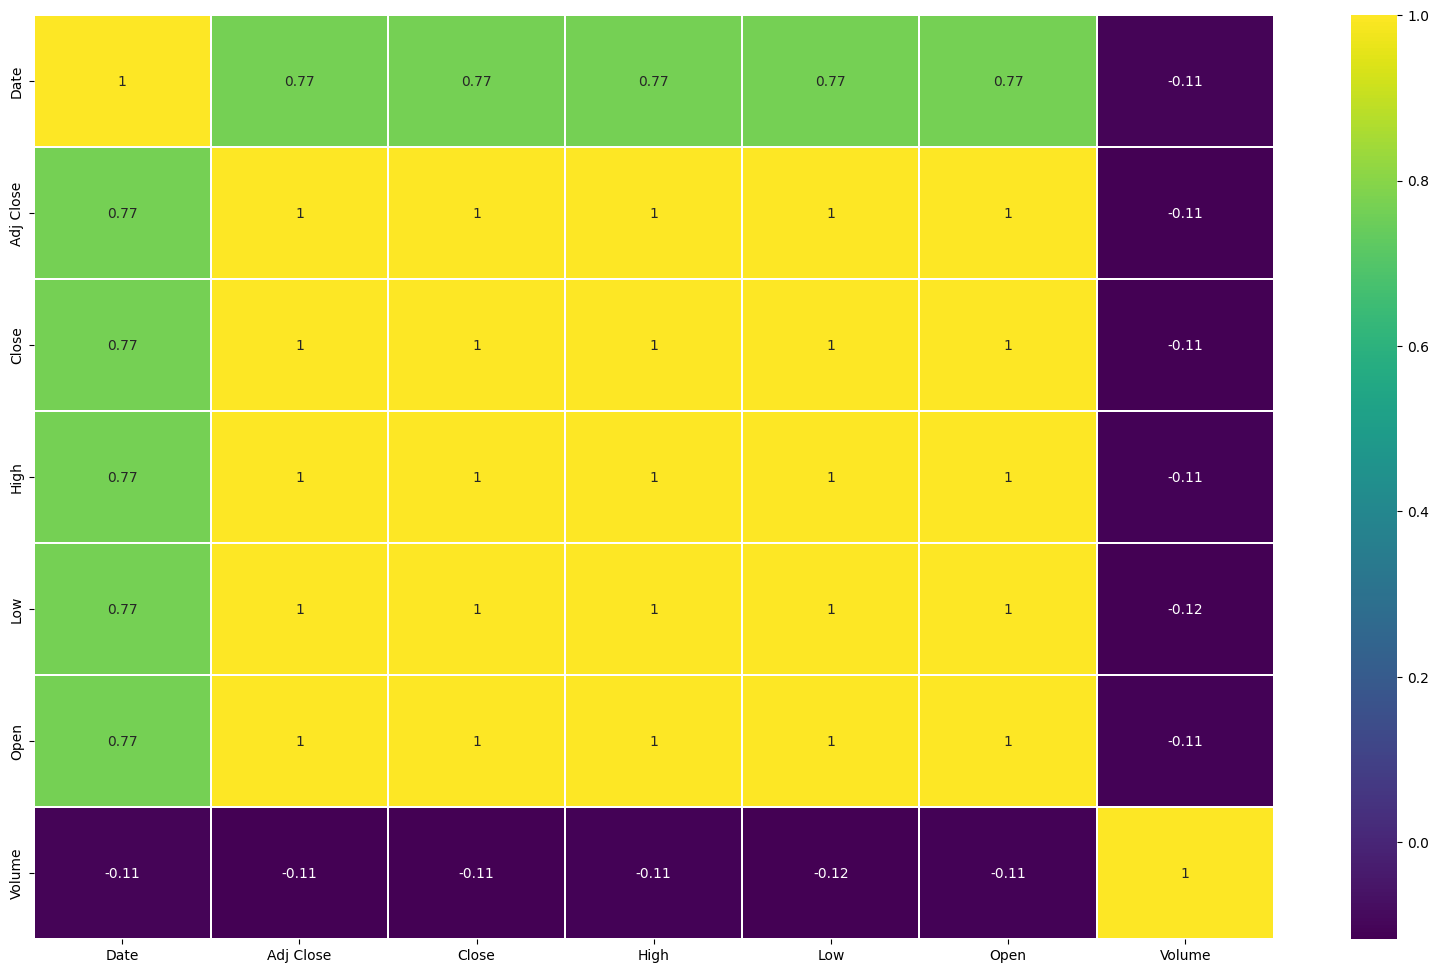

In [21]:
# Show correlation
fig, ax = plt.subplots(figsize = (20, 12))
ax = sns.heatmap(df_nvidia.corr(), cmap='viridis', cbar=True, annot=True, linewidths=0.2,ax=ax)
# save image
plt.savefig('nvidia-corr.png')
plt.show()

In [22]:
# Check if the DataFrame index is named "Date"
# This is useful to ensure compatibility when merging, plotting, or resampling
if df_nvidia.index.name == "Date":
    # If so, reset the index to move "Date" back into a regular column
    df_nvidia = df_nvidia.reset_index()

In [23]:
# Feature Engineering (Moving Averages and Volatility)

# Calculate the 50-day Simple Moving Average (SMA), which smooths the closing price by averaging it over the last 50 days to identify short-term trends.
df_nvidia['SMA_50'] = df_nvidia['Close'].rolling(window=50).mean()

# Compute the 200-day Simple Moving Average (SMA), which averages the closing prices from the past 200 days to recognize long-term trends.
df_nvidia['SMA_200'] = df_nvidia['Close'].rolling(window=200).mean()

# Calculate the 50-day rolling standard deviation (Volatility), which measures the dispersion of closing prices over the last 50 days, indicating market volatility.
df_nvidia['Volatility'] = df_nvidia['Close'].rolling(window=50).std()

df_nvidia.dropna(inplace=True)

In [24]:
# Display the dataframe
df_nvidia.head()

,Date,Adj Close,Close,High,Low,Open,Volume,SMA_50,SMA_200,Volatility
199,1539648000000000000,6.090191,6.14575,6.15700,5.94850,5.99825,408712000.0,6.656860,6.178069,0.321654
200,1539734400000000000,6.021566,6.07650,6.24700,6.02700,6.20850,329668000.0,6.649915,6.183533,0.330420
201,1539820800000000000,5.934114,5.98825,6.18525,5.92725,6.14650,524020000.0,6.640470,6.186915,0.342474
202,1539907200000000000,5.677456,5.72925,6.06375,5.69250,6.04400,613608000.0,6.626825,6.188863,0.364656
203,1540166400000000000,5.728243,5.78050,5.88300,5.67675,5.78200,368844000.0,6.615040,6.190840,0.382232


In [25]:
# Transform "Date" into a datetime format.
df_nvidia["Date"] = pd.to_datetime(df_nvidia["Date"], errors='coerce')

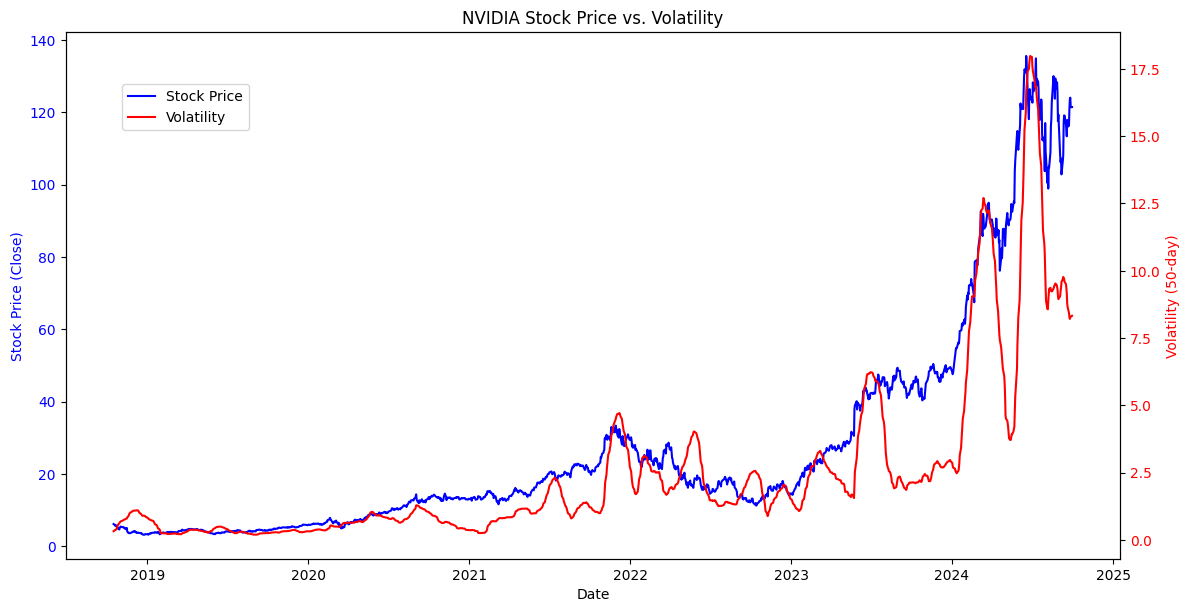

In [26]:
# Plot stock price and volatility
# Create a figure and axis for the primary y-axis (stock price)
fig, stock_ax = plt.subplots(figsize=(12, 6))

# Plot stock price
# Set label for x-axis
stock_ax.set_xlabel("Date")

# Set label and color for left y-axis (stock price)
stock_ax.set_ylabel("Stock Price (Close)", color="blue")

# Plot stock closing prices on the left y-axis
stock_line, = stock_ax.plot(df_nvidia["Date"], df_nvidia["Close"], label="Stock Price", color="blue")

# Color the y-axis tick labels to match the line color
stock_ax.tick_params(axis="y", labelcolor="blue")

# Create a second y-axis on the right for volatility
vola_ax = stock_ax.twinx()

# Set label and color for right y-axis (volatility)
vola_ax.set_ylabel("Volatility (50-day)", color="red")

# Plot 50-day rolling volatility on the right y-axis
vola_line, = vola_ax.plot(df_nvidia["Date"], df_nvidia["Volatility"], label="Volatility", color="red")

# Color the y-axis tick labels to match the line color
vola_ax.tick_params(axis="y", labelcolor="red")

# Combine both plots lines into a single legend
lines = [stock_line, vola_line]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Adjust layout to prevent label overlap
fig.tight_layout()

# Add a title to the entire figure
plt.title("NVIDIA Stock Price vs. Volatility")

# Save the plot as a PNG file, Display the plot
plt.savefig('nvidia-stock-price-volatility.png')
plt.show()

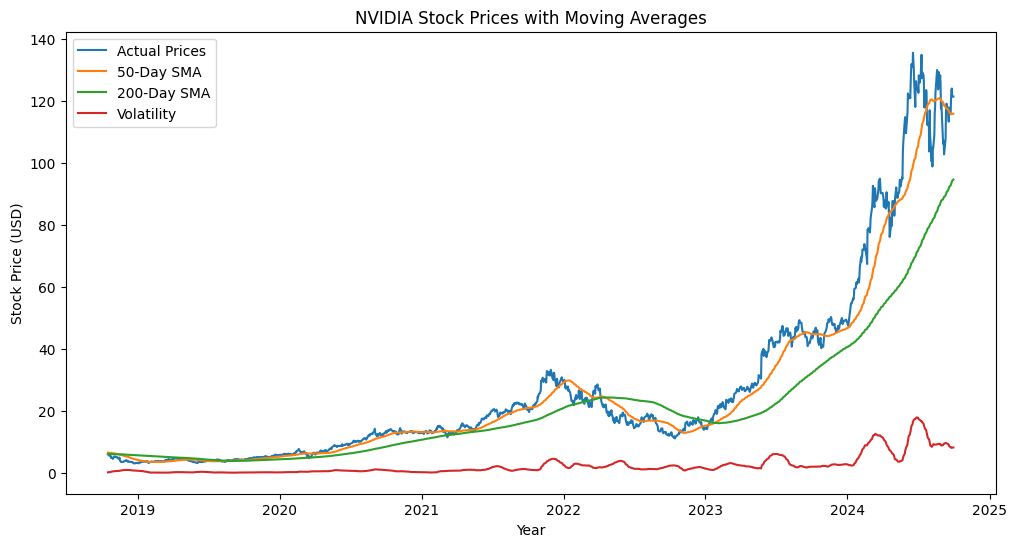

In [27]:
# Stock price with different Moving Average
plt.figure(figsize=(12, 6))

# Create a new figure with specified size
plt.plot(df_nvidia["Date"], df_nvidia["Close"], label="Actual Prices")

# Plot the 50-day Simple Moving Average
plt.plot(df_nvidia["Date"], df_nvidia["SMA_50"], label="50-Day SMA")

# Plot the 200-day Simple Moving Average
plt.plot(df_nvidia["Date"], df_nvidia["SMA_200"], label="200-Day SMA")

# Plot the 50-day rolling volatility
plt.plot(df_nvidia["Date"], df_nvidia["Volatility"], label="Volatility")

# Assign a title to the graph
plt.title("NVIDIA Stock Prices with Moving Averages")

# Label the x-axis
plt.xlabel("Year")

# Label the y-axis
plt.ylabel("Stock Price (USD)")

# Display a legend, Save the plot as a PNG file, Display the plot
plt.legend()
plt.savefig('nvidia-stock-price-moving-average.png')
plt.show()

In [28]:
# Define features and target
features = ['Adj Close', 'High', 'Low', 'Open', 'Volume', 'SMA_50', 'SMA_200', 'Volatility']
target = 'Close'

In [29]:
# Scale data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [30]:
# Create a function that generates lagged sequences for forecasting time series data.
def create_sequences(X, y, seq_len):

    # Initialize empty lists to hold input sequences and corresponding targets
    Xs, ys = [], []
    # Loop through the dataset starting from index 'seq_len' to the end
    for i in range(seq_len, len(X)):
        # Add a sequence of 'seq_len' preceding time steps from X to create a single input sequence.
        Xs.append(X[i - seq_len:i])
        # Append the corresponding y value (target) right after the sequence
        ys.append(y[i])
    # Convert lists to NumPy arrays and return
    return np.array(Xs), np.array(ys)

**LSTM DAILY PREDICTIONS**

In [31]:
# Scale the input features to a 0-1 range using MinMaxScaler
X_scaled = scaler_X.fit_transform(df_nvidia[features])

# Scale the target values (Close price) separately
y_scaled = scaler_y.fit_transform(df_nvidia[[target]])

# Set sequence length — use 60 previous days to forecast the next day.
sequence_length = 60

# Generate series of 60 days of data inputs along with their associated target values.
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Define training size as 80% of total sequences, preserving chronological order
train_size = int(0.8 * len(X_seq))

# Divide the dataset into training and testing sets (without shuffling, since it’s a time series).
X_train = X_seq[:train_size]
y_train = y_seq[:train_size]
X_test  = X_seq[train_size:]
y_test  = y_seq[train_size:]

# Specify the structure of the LSTM model.
model = Sequential([
    # Initial LSTM layer featuring 128 units and configured to return sequences for stacking.
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3), # Dropout to reduce overfitting
    LSTM(64), # Second LSTM layer featuring 64 units, producing only the final output value.
    Dropout(0.3), # Another dropout layer
    Dense(1) # Final dense layer to output one predicted value
])

# Train the model using the Adam optimizer and the loss function based on mean squared error.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Configure early stopping to end training when the loss no longer shows improvement.
early_stopping = EarlyStopping(
    monitor='loss', # Monitor training loss (could be 'val_loss' too)
    patience=15,    # Stop after 15 epochs with no improvement
    min_delta=0.0001, # Minimum change to be considered an improvement
    restore_best_weights=True, # Keep the best weights before overfitting started
    verbose=1 # Print early stopping info
    )

# Utilize the training data to train the model and assess it with the test data.
daily_history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Create predictions that are adjusted based on the test data.
y_pred_scaled = model.predict(X_test)

# Reverse the transformation of predictions in order to obtain the actual price values.
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Transform the true test values through inverse transformation in order to facilitate a comparison with the predicted outcomes.
y_actual = scaler_y.inverse_transform(y_test)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - loss: 0.0041 - val_loss: 0.0295
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 8.3349e-04 - val_loss: 0.0068
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 5.4823e-04 - val_loss: 0.0080
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 5.1345e-04 - val_loss: 0.0075
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 4.3407e-04 - val_loss: 0.0055
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - loss: 3.9243e-04 - val_loss: 0.0039
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 3.8292e-04 - val_loss: 0.0048
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 4.4786e-04 - val_loss: 0.0054
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 3.5311e-04 - val_loss: 0.0034
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 3.8656e-04 - val_loss: 0.0044
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 3.5759e-04 - val_loss: 0.0037


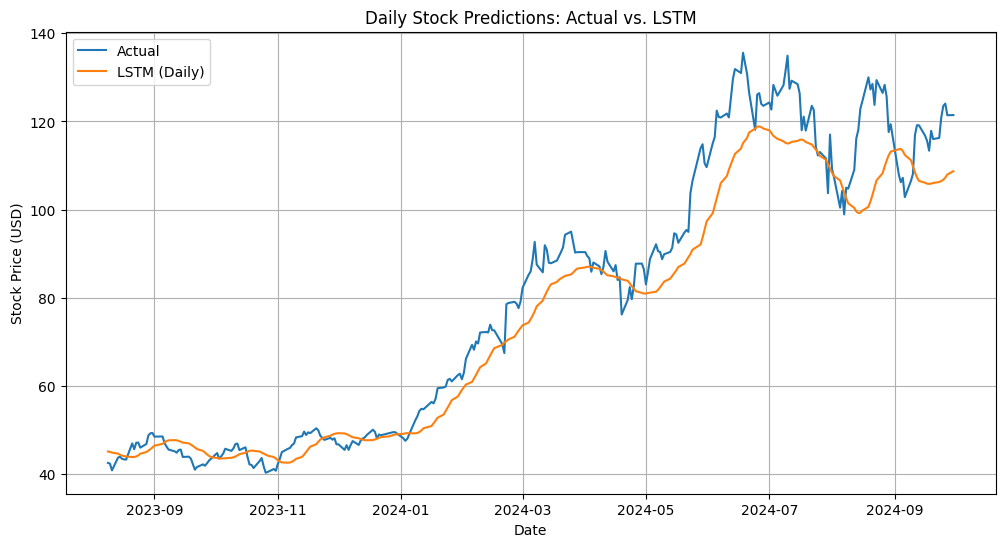

In [32]:
# Extract the corresponding dates for the test predictions,
# accounting for the sequence_length used in the LSTM
dates_daily = df_nvidia['Date'][train_size + sequence_length : len(df_nvidia)]

# Create a new figure with specified width and height
plt.figure(figsize=(12, 6))

# Plot actual stock prices (flattened to 1D for plotting)
plt.plot(dates_daily, y_actual.flatten(), label='Actual')

# Plot predicted stock prices from the LSTM model
plt.plot(dates_daily, y_pred.flatten(), label='LSTM (Daily)')

# Set the plot title
plt.title("Daily Stock Predictions: Actual vs. LSTM")

# Label of the x-axis and y-axis
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")

# Display a legend, enable grid for better visual guidance, Save the plot as a PNG file, Display the plot
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-daily-predication.png')
plt.show()

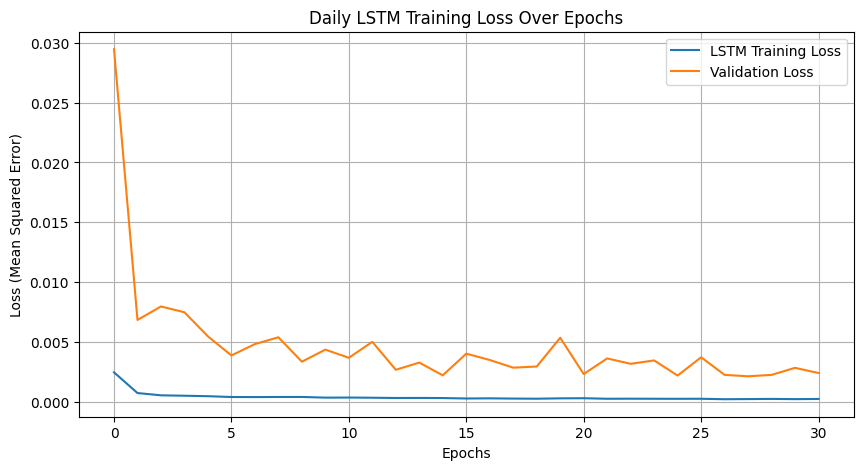

In [33]:
# Daily LSTM Training Loss Over Epochs
plt.figure(figsize=(10, 5))

# plot the training loss captured throughout the model's training process.
plt.plot(daily_history.history['loss'], label="LSTM Training Loss")
# Plot the validation loss to monitor generalization performance
plt.plot(daily_history.history['val_loss'], label='Validation Loss')

# Set label for the x-axis, y-axis and title
plt.xlabel("Epochs")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("Daily LSTM Training Loss Over Epochs")

# Show a legend, turn on the grid for enhanced visual assistance, save the chart as a PNG file, and display the plot.
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-daily-loss-epochs.png')
plt.show()

**LSTM WEEKLY PREDICTIONS**

In [34]:
# Resample the data to weekly frequency using the last trading day of each week
df_weekly = df_nvidia.set_index('Date').resample('W').last().reset_index()

# Scale weekly input features using the same MinMaxScaler approach
X_week_scaled = scaler_X.fit_transform(df_weekly[features])
# Scale the weekly target variable (Close price)
y_week_scaled = scaler_y.fit_transform(df_weekly[[target]])

# Create sequences: use 4 weeks of data to predict the next week's price
seq_length_week = 4
X_week_seq, y_week_seq = create_sequences(X_week_scaled, y_week_scaled, seq_length_week)

# Define training size (80%) without shuffling to preserve sequence order
week_train_size = int(0.8 * len(X_week_seq))

# Split into training and testing datasets
X_week_train = X_week_seq[:week_train_size]
y_week_train = y_week_seq[:week_train_size]
X_week_test  = X_week_seq[week_train_size:]
y_week_test  = y_week_seq[week_train_size:]

# Build the LSTM model for weekly data
model_week = Sequential([
    # The initial LSTM layer comprises 128 units and is configured to output sequences for subsequent layers.
    LSTM(128, return_sequences=True, input_shape=(X_week_train.shape[1], X_week_train.shape[2])),
    Dropout(0.3), # Dropout to reduce overfitting
    LSTM(64), # Second LSTM layer with 64 units, outputs final value
    Dropout(0.3), # More dropout for regularization
    Dense(1) # Output layer to predict a single value
])
# Configure the model using the Adam optimizer along with the MSE loss function.
model_week.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Set up early stopping to prevent overfitting
early_stopping_week = EarlyStopping(
    monitor='loss', # Monitor training loss
    patience=10,    # Stop after 10 epochs with no improvement
    min_delta=0.0001, # Minimum loss change to count as improvement
    restore_best_weights=True, # Retrieve the optimal weights of the model
    verbose=1 # Print stopping messages
    )

# Train the weekly LSTM model
week_history = model_week.fit(X_week_train, y_week_train, epochs=100, batch_size=32, validation_data=(X_week_test, y_week_test), callbacks=[early_stopping_week], verbose=1)

# Predict stock prices using the trained model
y_week_pred_scaled = model_week.predict(X_week_test)
# Inverse transform predictions to get actual price values
y_week_pred = scaler_y.inverse_transform(y_week_pred_scaled)
# Inverse transform true test values for comparison
y_week_actual = scaler_y.inverse_transform(y_week_test)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.0114 - val_loss: 0.3171
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0089 - val_loss: 0.2551
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0062 - val_loss: 0.2005
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0045 - val_loss: 0.1534
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0030 - val_loss: 0.1164
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0019 - val_loss: 0.0884
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0018 - val_loss: 0.0682
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0016 - val_loss: 0.0540
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0021 - val_loss: 0.0436
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0013 - val_loss: 0.0362
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0013 - val_loss: 0.0302
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0011 - val_lo

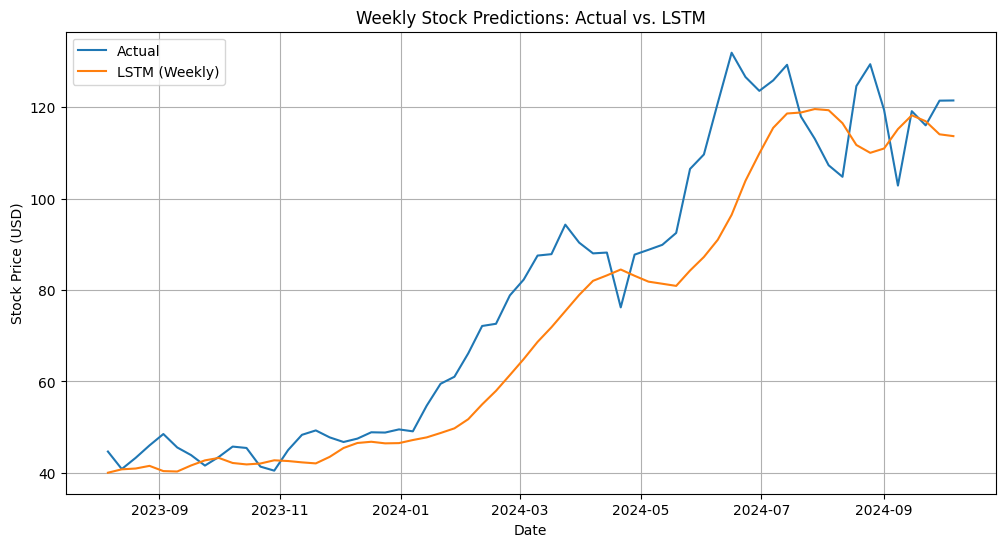

In [35]:
# Extract the correct range of weekly dates to align with prediction output
dates_weekly = df_weekly['Date'][week_train_size + seq_length_week : len(df_weekly)]

# Create a new figure with specified dimensions
plt.figure(figsize=(12, 6))

# Plot the actual weekly stock prices (target values)
plt.plot(dates_weekly, y_week_actual, label='Actual')

# Plot the LSTM model's predicted weekly stock prices
plt.plot(dates_weekly, y_week_pred, label='LSTM (Weekly)')

# Include a title for the graph, and label the axes for both x and y.
plt.title("Weekly Stock Predictions: Actual vs. LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")

# Show a legend, turn on the grid for improved visual clarity, save the image as a PNG file, and display the plot.
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-weekly-predication.png')
plt.show()

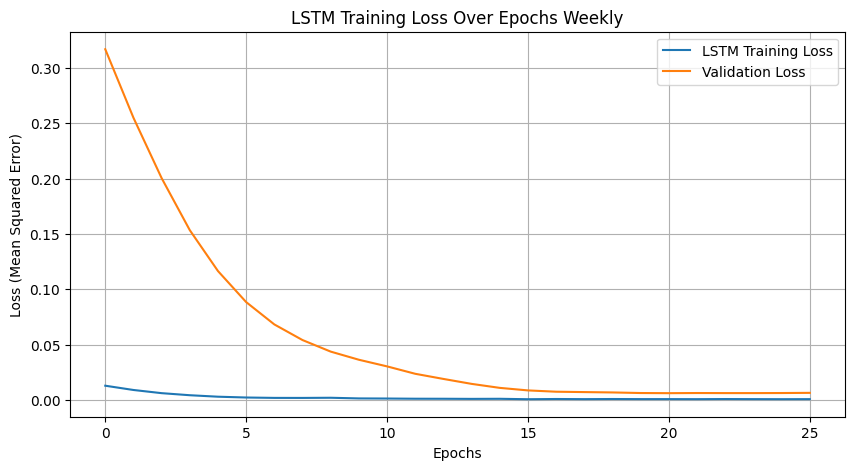

In [36]:
# Create a figure with a defined dimension for the plot depicting weekly training loss.
plt.figure(figsize=(10, 5))
# Plot the training loss values over each epoch from model history
plt.plot(week_history.history['loss'], label="LSTM Training Loss")
# Plot the validation loss values to observe model generalization
plt.plot(week_history.history['val_loss'], label='Validation Loss')

# Label the x-axis to show the number of epochs.
plt.xlabel("Epochs")
# Label the y-axis to show the loss value (Mean Squared Error).
plt.ylabel("Loss (Mean Squared Error)")
# Add a title specific to the weekly LSTM model training
plt.title("LSTM Training Loss Over Epochs Weekly")

# Show a legend, turn on the grid for improved visual clarity, save the image as a PNG file, and display the plot.
plt.legend()
plt.grid(True)
plt.savefig('nvidia-lstm-weekly-loss-epochs.png')
plt.show()

**Linear Regression**

In [37]:
# Reshape the 3D input (used for LSTM) to 2D format (samples, features) for Linear Regression
X_train_lr = X_train.reshape(X_train.shape[0], -1)  # Flatten training data
X_test_lr = X_test.reshape(X_test.shape[0], -1) # Flatten test data

# Initialize and train the Linear Regression model on the flattened training data
linear_model = LinearRegression()
linear_model.fit(X_train_lr, y_train)

# Use the trained model to predict stock prices on the test set
y_pred_lr = linear_model.predict(X_test_lr)

# Inverse transform the predicted values to return them to original price scale
y_pred_lr_inv = scaler_y.inverse_transform(y_pred_lr)

# Inverse transform the actual test values for comparison
y_actual_lr_inv = scaler_y.inverse_transform(y_test)

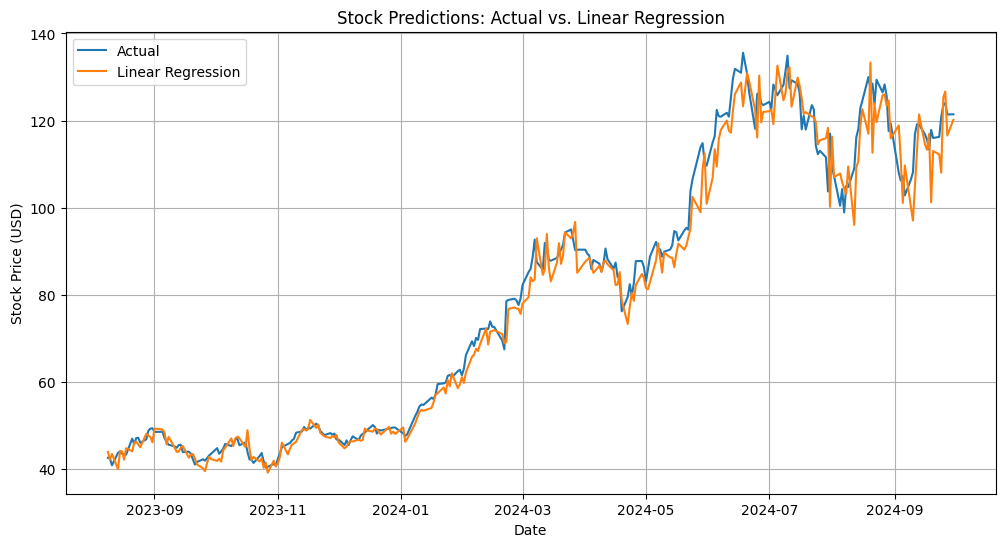

In [38]:
# Select the date range that aligns with the test set predictions (after sequence window)
dates_daily = df_nvidia['Date'][train_size + sequence_length : len(df_nvidia)]

# Create a new plot with specified figure size
plt.figure(figsize=(12, 6))

# Plot the actual stock prices (true values)
plt.plot(dates_daily, y_actual.flatten(), label='Actual')

# Plot the predicted stock prices from Linear Regression
plt.plot(dates_daily, y_pred_lr_inv.flatten(), label='Linear Regression')

# Add a title to the plot
plt.title("Stock Predictions: Actual vs. Linear Regression")

# Label the x-axis with 'Date'
plt.xlabel("Date")

# Label the y-axis with 'Stock Price (USD)'
plt.ylabel("Stock Price (USD)")

# Show a legend, turn on the grid for improved visual clarity, save the image as a PNG file, and display the plot.
plt.legend()
plt.grid(True)
plt.savefig('nvidia-linear-regression-predication.png')
plt.show()

**Random Forest**

In [39]:
# Flatten the 3D LSTM input data into 2D format (samples, features) for Random Forest
X_train_rf = X_train.reshape(X_train.shape[0], -1) # Flatten training features
X_test_rf = X_test.reshape(X_test.shape[0], -1) # Flatten test features

# Initialize a Random Forest Regressor with 100 decision trees and a designated random seed for reproducibility.
random_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest model on the flattened training data
random_model.fit(X_train_rf, y_train)

# Predict the stock prices on the test set
y_pred_rf = random_model.predict(X_test_rf)

# Reshape predictions and inverse transform them to original stock price scale
y_pred_rf_inv = scaler_y.inverse_transform(y_pred_rf.reshape(-1, 1))

# Inverse transform the actual test values to ensure accurate comparison.
y_actual_rf_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

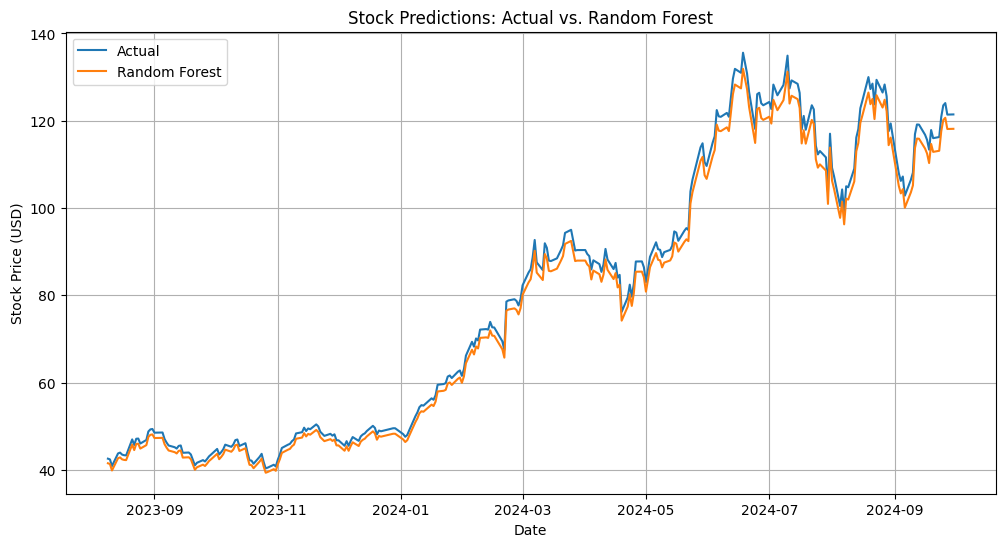

In [40]:
# Select the appropriate date range that aligns with test predictions,
# accounting for the sequence length offset
dates_daily = df_nvidia['Date'][train_size + sequence_length : len(df_nvidia)]

plt.figure(figsize=(12, 6))

# Plot actual stock prices (ground truth) for the selected dates
plt.plot(dates_daily, y_actual.flatten(), label='Actual')

# Plot stock price predictions made by the Random Forest model
plt.plot(dates_daily, y_actual_rf_inv.flatten(), label='Random Forest')

# Set label for the x-axis, y-axis and title
plt.title("Stock Predictions: Actual vs. Random Forest")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")

# Show a legend, turn on the grid for improved visual clarity, save the image as a PNG file, and display the plot.
plt.legend()
plt.grid(True)
plt.savefig('nvidia-random-forest-predication.png')
plt.show()

**ARIMA**

In [41]:
# Import auto_arima from pmdarima to automatically find the best (p,d,q) parameters
from pmdarima import auto_arima

# Define the training size as 80% of the dataset
train_size = int(len(df_nvidia) * 0.8)

# Split the data into training and testing sets based on Close prices
train, test = df_nvidia['Close'][:train_size], df_nvidia['Close'][train_size:]

# Use auto_arima to automatically determine the best ARIMA order (p,d,q)
# seasonal=False: for non-seasonal data
# stepwise=True: use stepwise search to reduce computation
# suppress_warnings=True: ignore convergence warnings
auto_model = auto_arima(train, seasonal=False, stepwise=True, trace=False, suppress_warnings=True)

# Extract the best order (p, d, q) from the auto_arima model
best_order = auto_model.order

# Print the selected ARIMA order
print(f"Best ARIMA Order: ({best_order})")

# Initialize and train the ARIMA model using the optimal order
arima_model = ARIMA(train, order=best_order)
fitted_model = arima_model.fit()

# Forecast the next 'len(test)' values to compare with test set
forecast = fitted_model.forecast(steps=len(test))

Best ARIMA Order: ((2, 1, 2))


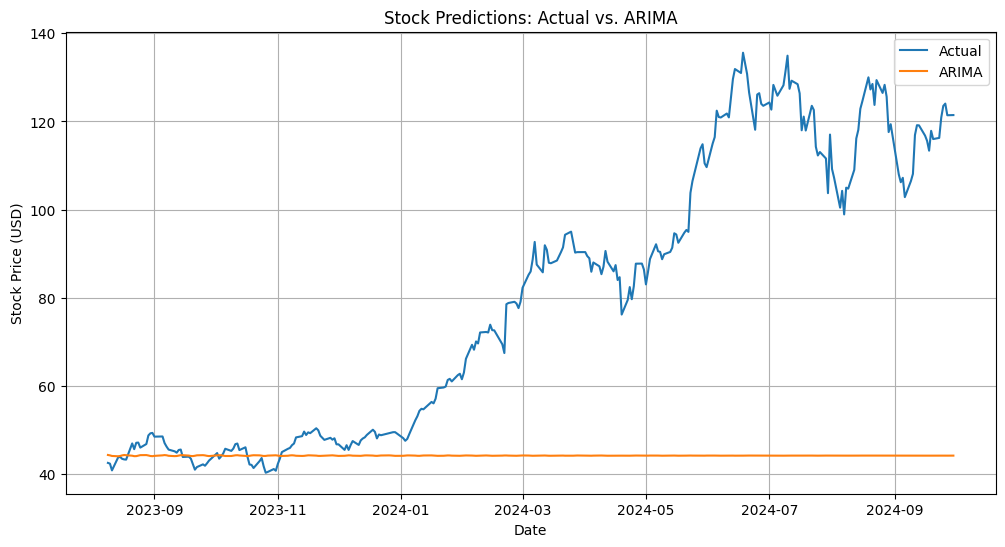

In [42]:
# Extract the corresponding dates for the forecast period
# Ensure alignment with the number of predictions (same as y_actual)
dates_arima = df_nvidia['Date'][-len(y_actual):]

# Create a new figure for plotting with specified size
plt.figure(figsize=(12, 6))

# Plot the actual stock prices (ground truth) over the selected date range
plt.plot(dates_arima, y_actual.flatten(), label='Actual')

# Plot the ARIMA forecast, limited to match the length of actual values
plt.plot(dates_arima, forecast[:len(y_actual)], label='ARIMA')

# Add a title to the plot
plt.title("Stock Predictions: Actual vs. ARIMA")

# Label the x-axis as Date
plt.xlabel("Date")

# Label the y-axis as 'Stock Price (USD)'
plt.ylabel("Stock Price (USD)")

# Display a legend, enable grid for better visual guidance, Save the plot as a PNG file, Display the plot
plt.legend()
plt.grid(True)
plt.savefig('nvidia-arima-stock-predication.png')
plt.show()

In [43]:
# Define a function to evaluate a regression model using common metrics
def evaluate_model(y_true, y_pred, model_name):
    # Calculate the Mean Absolute Error (MAE) by averaging the absolute differences between predicted values and actual values.
    mae = mean_absolute_error(y_true, y_pred)

    # Calculating the Root Mean Squared Error (RMSE) gives greater weight to larger errors compared to Mean Absolute Error (MAE).
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # The R² Score, also known as the coefficient of determination, quantifies how effectively the predictions account for the variance.
    r2 = r2_score(y_true, y_pred)

    # Return the model name and all metrics rounded to 4 decimal places
    return model_name, round(mae, 4), round(rmse, 4), round(r2, 4)

+-------------------+---------+---------+------------+
| Model             |     MAE |    RMSE |   R² Score |
+===================+=========+=========+============+
| Linear Regression |  2.6547 |  4.0176 |     0.9823 |
+-------------------+---------+---------+------------+
| Random Forest     | 34.1292 | 45.2188 |    -1.2401 |
+-------------------+---------+---------+------------+
| LSTM Daily        |  6.1636 |  8.3972 |     0.9271 |
+-------------------+---------+---------+------------+
| LSTM Weekly       |  9.1088 | 11.8532 |     0.8573 |
+-------------------+---------+---------+------------+
| ARIMA             | 34.4113 | 46.1709 |    -1.1905 |
+-------------------+---------+---------+------------+


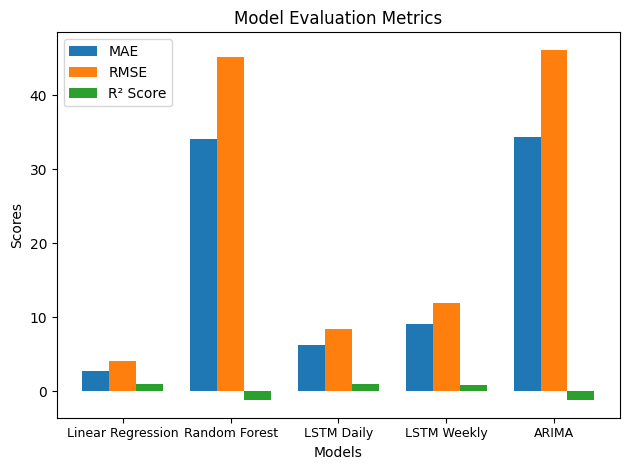

In [44]:
from tabulate import tabulate

# Run evaluation on all models and collect results into a list
results = [
    evaluate_model(np.array(y_actual_lr_inv).flatten(), np.array(y_pred_lr_inv).flatten(), "Linear Regression"),
    evaluate_model(np.array(y_actual_rf_inv).flatten(), np.array(y_pred_rf_inv).flatten(), "Random Forest"),
    evaluate_model(np.array(y_actual).flatten(), np.array(y_pred).flatten(), "LSTM Daily"),
    evaluate_model(np.array(y_week_actual).flatten(), np.array(y_week_pred).flatten(), "LSTM Weekly"),
    evaluate_model(np.array(test).flatten(), np.array(forecast).flatten(), "ARIMA"),
]

# Define table headers for the tabulated output
headers = ["Model", "MAE", "RMSE", "R² Score"]

# Print the evaluation results in a well-formatted grid table
print(tabulate(results, headers=headers, tablefmt="grid"))

# Unpack results into individual lists for plotting
model_names, mae_values, rmse_values, r2_values = zip(*results)

# Create X-axis positions for bar groups
x = np.arange(len(model_names))
width = 0.25

# Create a bar chart to visualize model performance metrics
fig, ax = plt.subplots()

# Plot MAE values slightly to the left
ax.bar(x - width, mae_values, width, label='MAE')
# Plot RMSE values centered
ax.bar(x, rmse_values, width, label='RMSE')
# Plot R² Score values slightly to the right
ax.bar(x + width, r2_values, width, label='R² Score')

# Set the y-axis label
ax.set_ylabel('Scores')
# Set the chart title
ax.set_title('Model Evaluation Metrics')

# Set the positions and labels for the x-axis ticks
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=9)
ax.set_xlabel('Models')
ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('nvidia-model-evaluation.png')
plt.show()



**Time Horizon Impact**

In [45]:
# Convert the 'Date' column to datetime format, if it exists
if 'Date' in df_nvidia.columns:
    df_nvidia['Date'] = pd.to_datetime(df_nvidia['Date'], unit='ns', errors='coerce') # Convert using nanoseconds if needed
    df_nvidia.set_index('Date', inplace=True) # Set 'Date' as the index for time series plotting

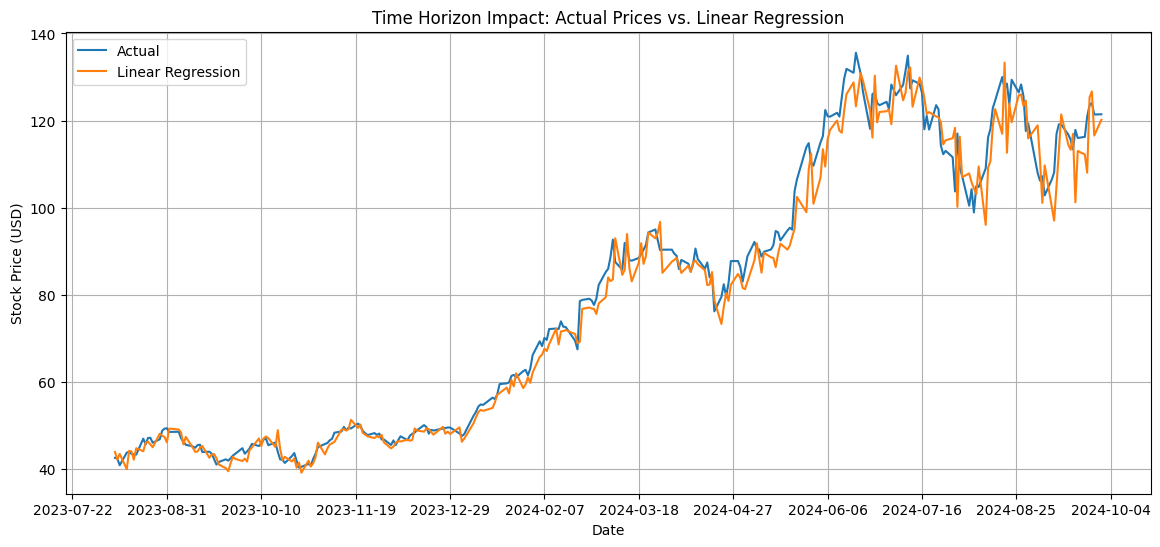

In [46]:
# Time Horizon Impact of Linear Regression
plt.figure(figsize=(14, 6))
# Plot the actual stock prices for the test period
plt.plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
# Plot the Linear Regression predicted stock prices
plt.plot(df_nvidia.index[-len(y_test):], y_pred_lr_inv, label='Linear Regression')

# Format the x-axis to limit the number of date labels for readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))

plt.legend(loc='upper left')
plt.title("Time Horizon Impact: Actual Prices vs. Linear Regression")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.savefig('nvidia-linear-regression-time-horizon-comparison.png')
plt.show()

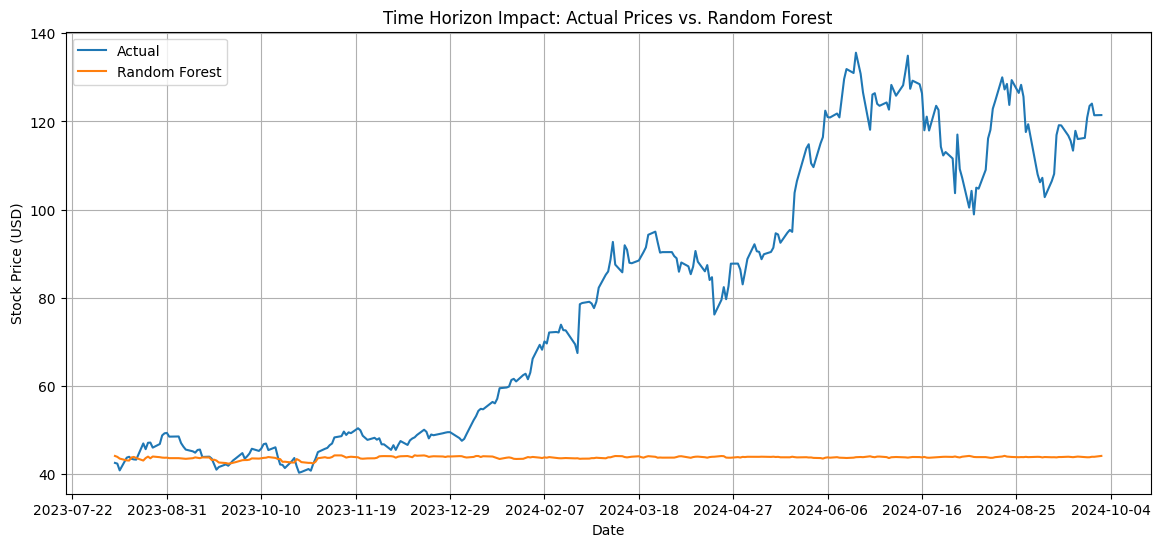

In [47]:
# Time Horizon Impact of Random Forest
plt.figure(figsize=(14, 6))
# Plot the actual stock prices for the test period
plt.plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
# Plot the Random Forest predicted stock prices
plt.plot(df_nvidia.index[-len(y_test):], y_pred_rf_inv, label='Random Forest')

# Format the x-axis to limit the number of date labels for readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))

plt.legend(loc='upper left')
plt.title("Time Horizon Impact: Actual Prices vs. Random Forest")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.savefig('nvidia-random-forest-time-horizon-comparison.png')
plt.show()

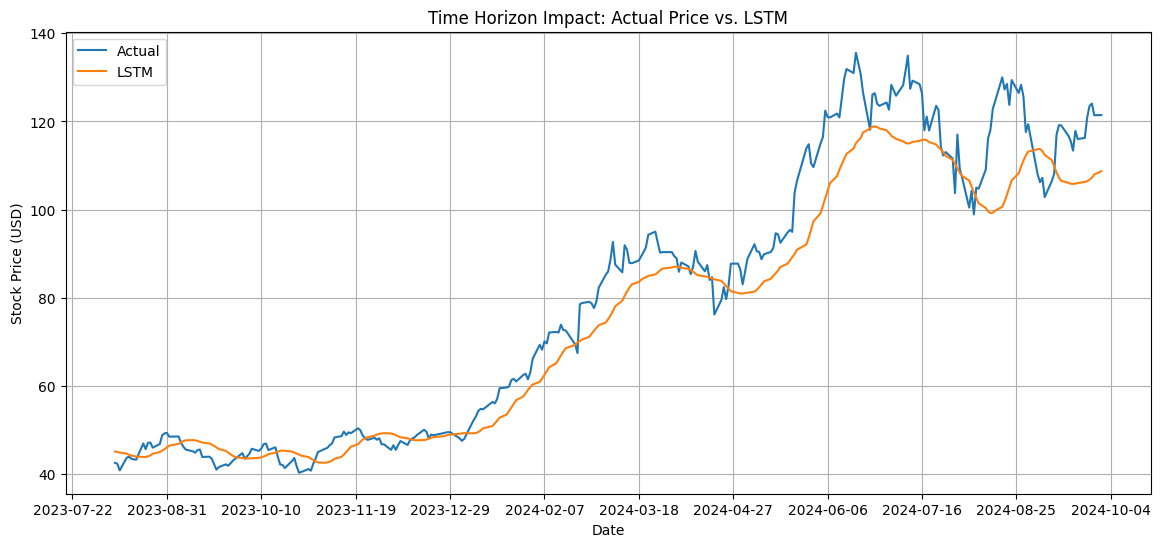

In [48]:
# Time Horizon Impact of LSTM
plt.figure(figsize=(14, 6))
# Plot the actual stock prices for the test period
plt.plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
# Plot the LSTM predicted stock prices
plt.plot(df_nvidia.index[-len(y_test):], y_pred.flatten(), label='LSTM')

# Format the x-axis to limit the number of date labels for readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))

plt.legend(loc='upper left')
plt.title("Time Horizon Impact: Actual Price vs. LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.savefig('nvidia-lstm-time-horizon-comparison.png')
plt.show()

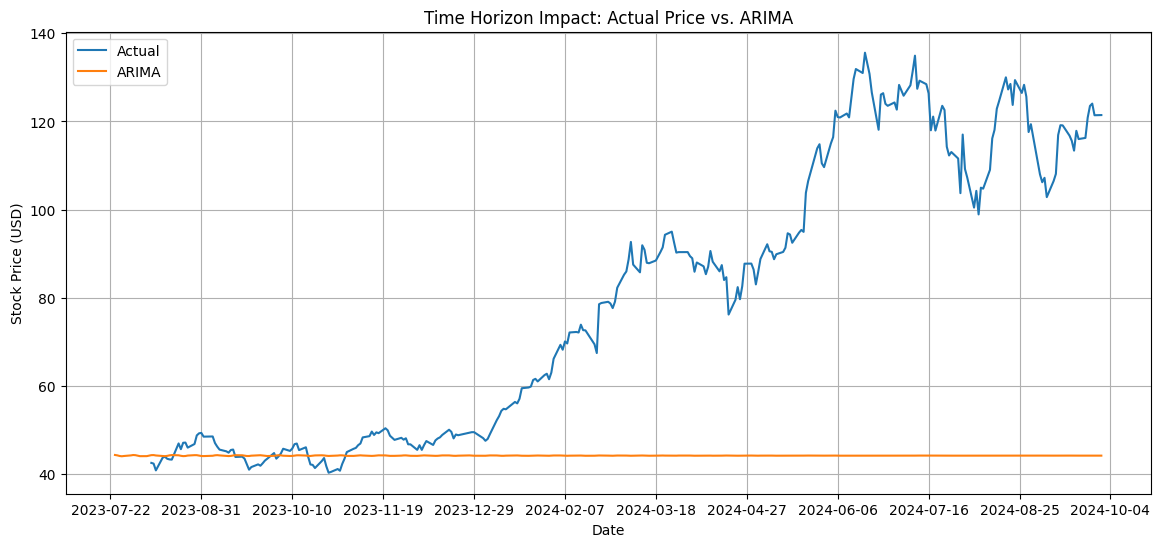

In [49]:
# Time Horizon Impact of ARIMA
plt.figure(figsize=(14, 6))
# Plot the actual stock prices for the test period
plt.plot(df_nvidia.index[-len(y_test):], y_actual, label='Actual')
# Plot the ARIMA predicted stock prices
plt.plot(df_nvidia.index[-len(test):], forecast, label='ARIMA')

# Format the x-axis to limit the number of date labels for readability
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(12))

plt.legend(loc='upper left')
plt.title("Time Horizon Impact: Actual Price vs. ARIMA")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.grid(True)
plt.savefig('nvidia-arima-time-horizon-comparison.png')
plt.show()